Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Instantiating visualizer


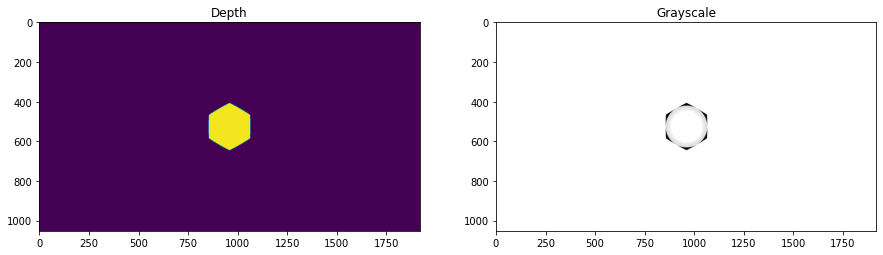

In [1]:
# read in untransformed bolt
# The untransformed location of the bolt is such that the center of the head is at 0,0,0
# and it is pointing in the direction and centered on the positive x axis.
# For example, rotating it around the z axis 90 degrees will make it appear pointing left
from utility.pose_data import get_bolt_depthimage, show_depthimage, make_pointcloud, get_random_transform
from utility.transformation_matrix import TransformationMatrix
from utility.visualizer import visualizer as vis

depthimage = get_bolt_depthimage()
show_depthimage(depthimage)

x=0.0, y=0.0, z=0.0
x_rotate=0.0°, y_rotate=0.0°, z_rotate=90.0°


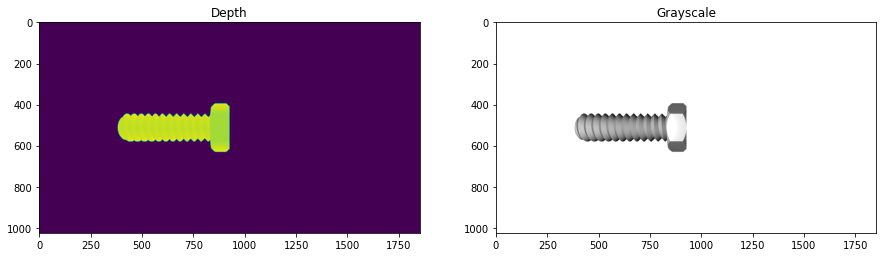

In [2]:
transform = TransformationMatrix.from_xyzwpr([0,0,0,0,0,90])
print(transform)
depthimage = get_bolt_depthimage(transform)
show_depthimage(depthimage)

x=5.39, y=43.89, z=10.9
x_rotate=-0.0°, y_rotate=2.58°, z_rotate=-17.84°


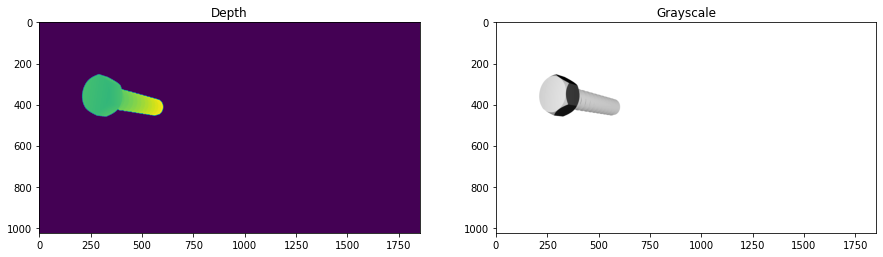

Now I'm a point cloud. Try moving me around!


In [3]:
transform = get_random_transform()
print(transform)
depthimage = get_bolt_depthimage(transform)
show_depthimage(depthimage)
pcd = make_pointcloud(depthimage)
print('Now I\'m a point cloud. Try moving me around!')
vis.draw_geometries([pcd], moveable=False)

In [ ]:
rot = Rotation.from_matrix(p).as_euler('xyz')
R.from_euler('xyz', rot).as_matrix()

In [46]:
np.unravel_index(np.argmin(np.ones((5,5)), axis=None), np.ones((5,5)).shape)

(0, 0)

Truth
x=29.96, y=41.8, z=-5.93
x_rotate=-0.0°, y_rotate=9.26°, z_rotate=16.53°


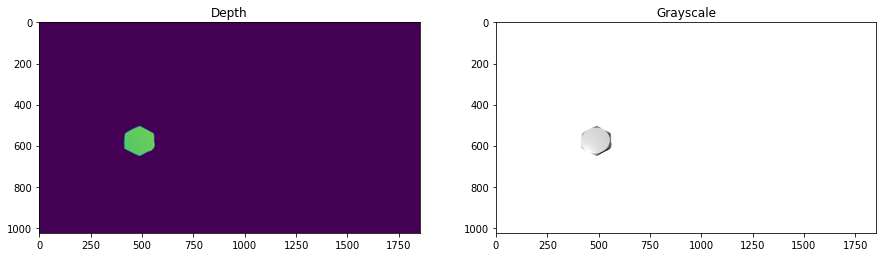

0
5
10
15
20
25
30
35
20 20
[0, 0, 0]
Estimate
x=31.63, y=43.74, z=-4.82
x_rotate=0.0°, y_rotate=0.0°, z_rotate=0.0°

Error: 7.818


In [136]:
import numpy as np
from scipy.spatial.transform import Rotation as R


def rotation_between_vectors(u, v):
    # u and v are both 3D unit vectors
    axis = np.cross(u, v)
    unit = axis / np.linalg.norm(axis)
    angle = np.arccos(np.dot(u, v.transpose()))
    rotvec = unit * angle
    return R.from_rotvec(rotvec)


def estimator(transformed_depthimage, debug=False):
    orig_normal = np.array([1,0,0]) # the bolt head is initially pointed in the x direction
    orig_center = np.array([0,0,0]) # the bolt head is initially centered at 0,0,0

    trns_pcd = make_pointcloud(transformed_depthimage)
    trns_center = trns_pcd.get_center()
    tr = (trns_center - orig_center)
    
    fitn = np.zeros((40,40)) + 1000000000
    
    
    
#     transformed_pcd.compute_point_cloud_distance(A_pd)

    
    for i in range(0,40,5):
        print(i)
        for j in range(0,40,5):    
            A = TransformationMatrix.from_xyzwpr([tr[0],tr[1],tr[2],0,i-20,j-20])
            A_im = get_bolt_depthimage(A)
            A_pd = make_pointcloud(A_im)
            
            fitn[i,j] = np.asarray(transformed_pcd.compute_point_cloud_distance(A_pd)).sum()
            

#             reg_p2p = o3d.pipelines.registration.registration_icp(A_pd,
#                 trns_pcd, 0.1, TransformationMatrix.compose(R.from_euler('xyz', [0,i-20,j-20],degrees=True).as_matrix(), translation),o3d.pipelines.registration.TransformationEstimationPointToPoint())
#             fitn[i,j] = (reg_p2p.fitness)
    
    i_idx, j_idx = np.unravel_index(np.argmin(fitn, axis=None),fitn.shape)
#     reg_p2p = o3d.pipelines.registration.registration_icp(A_pd,
#                 trns_pcd, 0.1, TransformationMatrix.compose(R.from_euler('xyz', [0,i_idx-20,j_idx-20],degrees=True).as_matrix(), translation),o3d.pipelines.registration.TransformationEstimationPointToPoint())
            
    
    print(i_idx,j_idx)
#     p = np.array(reg_p2p.transformation[0:3,0:3])
#     rot = R.from_matrix(p).as_euler('xyz')
    rot  = [0,i_idx-20,j_idx-20]
    print(rot)
#     rot = [0,0,0] # dummy values
    rot[0] = 0 # the rotation in x_rotate will always be 0 because I made that constraint
    rot = R.from_euler('xyz', rot,degrees=True).as_matrix()
    return TransformationMatrix.compose(rot, tr)

transform = get_random_transform()#TransformationMatrix.from_xyzwpr([5,-3,10,0,5,0])
print('Truth')
print(transform)
transformed = get_bolt_depthimage(transform)
transformed_pcd = make_pointcloud(transformed)

show_depthimage(transformed)
vis.draw_geometries([transformed_pcd], moveable=False)
estimate = estimator(transformed, debug=False)
print('Estimate')
print(estimate)
from utility.pose_estimation import transform_error, evaluate_random

print('\nError:', transform_error(estimate, transform).round(3))

In [163]:
print(transformed_pcd.get_axis_aligned_bounding_box())

AxisAlignedBoundingBox: min: (29.3562, 38.2662, -12.3913), max: (58.471, 51.8016, 1.93701)


In [141]:
translation

array([ 5.79987444, -0.70270534, 10.11570691])

In [173]:
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors

In [175]:
def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''


    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

#     assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


In [179]:
B = np.asarray(transformed_pcd.points)
A = np.asanyarray(A_pd.points)
T, distances, iterations = icp(B, A)



In [182]:
rot = R.from_matrix(T[0:3,0:3]).as_euler('xyz')
R.from_euler('xyz', rot).as_matrix()

array([[ 0.86848232,  0.48766511, -0.08900116],
       [-0.48891586,  0.87228808,  0.00864803],
       [ 0.08185199,  0.03600341,  0.99599398]])

In [183]:
rot

array([ 0.03613249, -0.08194367, -0.5127345 ])

In [166]:
A = TransformationMatrix.from_xyzwpr([0,0,0,0,0,0])
A_im = get_bolt_depthimage(A)
A_pd = make_pointcloud(A_im)

np.asarray(transformed_pcd.compute_point_cloud_distance(A_pd))

array([49.52769628, 49.48884839, 49.54427779, ..., 50.02472466,
       50.41799673, 50.81790685])

In [148]:
orig_normal = np.array([1,0,0]) # the bolt head is initially pointed in the x direction
orig_center = np.array([0,0,0]) # the bolt head is initially centered at 0,0,0

trns_pcd = make_pointcloud(transformed)
trns_center = trns_pcd.get_center()
tr = (trns_center - orig_center)

fitn = np.zeros((40,40)) + 100000000



for i in range(0,40,5):
    print(i)
    for j in range(0,40,5):    
        A = TransformationMatrix.from_xyzwpr([tr[0],tr[1],tr[2],0,i-20,j-20])
        A_im = get_bolt_depthimage(A)
        A_pd = make_pointcloud(A_im)

        fitn[i,j] = np.sum(np.asarray(transformed_pcd.compute_point_cloud_distance(A_pd))[0:5])


#             reg_p2p = o3d.pipelines.registration.registration_icp(A_pd,
#                 trns_pcd, 0.1, TransformationMatrix.compose(R.from_euler('xyz', [0,i-20,j-20],degrees=True).as_matrix(), translation),o3d.pipelines.registration.TransformationEstimationPointToPoint())
#             fitn[i,j] = (reg_p2p.fitness)
    
i_idx, j_idx = np.unravel_index(np.argmin(fitn, axis=None),fitn.shape)


# p = np.array(reg_p2p.transformation[0:3,0:3])
# rot = R.from_matrix(p).as_euler('xyz',degrees = True)

0
5
10
15
20
25
30
35


In [149]:
i_idx, j_idx = np.unravel_index(np.argmin(fitn, axis=None),fitn.shape)
i_idx, j_idx

(25, 10)

In [140]:
fitn[0,0]

27890.847321728237

In [91]:
rot = R.from_matrix(p).as_euler('xyz',degrees = True)
rot

array([ 39.31330723, -57.30539449, -62.05028718])

In [70]:
translation

array([25.29523308, 12.64775182, -2.6661628 ])

In [74]:
reg_p2p = o3d.pipelines.registration.registration_icp(A_pd,
        trns_pcd, 0.1, TransformationMatrix.compose(R.from_euler('xyz',[0,-0.167,-0.2]).as_matrix(), translation),o3d.pipelines.registration.TransformationEstimationPointToPoint())
# fitn[i,j] = (reg_p2p.fitness)
print(reg_p2p)

RegistrationResult with fitness=1.112347e-03, inlier_rmse=3.780019e-02, and correspondence_set size of 40
Access transformation to get result.


In [8]:

import open3d as o3d
# source = np.asarray(A_pd.points).transpose()


# reg_p2p = o3d.pipelines.registration.registration_icp(A_pd,
#         transformed_pcd, 0.3, TransformationMatrix.compose(R.from_euler('xyz', [0,0,0]).as_matrix(), ret_t.squeeze()),o3d.pipelines.registration.TransformationEstimationPointToPoint())

In [71]:
np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])

TypeError: from_euler() takes at least 2 positional arguments (1 given)

In [64]:
i_idx,j_idx

(0, 0)

In [ ]:
import cv2
import numpy
import copy
import pylab
import time
import sys
import sklearn.neighbors
import scipy.optimize

In [6]:
# def icp(a, b,
#         max_time = 30
#     ):


#     def res(p,src,dst):
#         T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
#         [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
#         [0 ,0 ,1 ]])
#         n = numpy.size(src,0)
#         xt = numpy.ones([n,3])
#         xt[:,:-1] = src
#         xt = (xt*T.T).A
#         d = numpy.zeros(numpy.shape(src))
#         d[:,0] = xt[:,0]-dst[:,0]
#         d[:,1] = xt[:,1]-dst[:,1]
#         r = numpy.sum(numpy.square(d[:,0])+numpy.square(d[:,1]))
#         return r

#     def jac(p,src,dst):
#         T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
#         [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
#         [0 ,0 ,1 ]])
#         n = numpy.size(src,0)
#         xt = numpy.ones([n,3])
#         xt[:,:-1] = src
#         xt = (xt*T.T).A
#         d = numpy.zeros(numpy.shape(src))
#         d[:,0] = xt[:,0]-dst[:,0]
#         d[:,1] = xt[:,1]-dst[:,1]
#         dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],
#                             [ numpy.cos(p[2]),-numpy.sin(p[2])]])
#         dUdth = (src*dUdth_R.T).A
#         g = numpy.array([  numpy.sum(2*d[:,0]),
#                         numpy.sum(2*d[:,1]),
#                         numpy.sum(2*(d[:,0]*dUdth[:,0]+d[:,1]*dUdth[:,1])) ])
#         return g
    
#     def hess(p,src,dst):
#         n = numpy.size(src,0)
#         T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
#         [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
#         [0 ,0 ,1 ]])
#         n = numpy.size(src,0)
#         xt = numpy.ones([n,3])
#         xt[:,:-1] = src
#         xt = (xt*T.T).A
#         d = numpy.zeros(numpy.shape(src))
#         d[:,0] = xt[:,0]-dst[:,0]
#         d[:,1] = xt[:,1]-dst[:,1]
#         dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],[numpy.cos(p[2]),-numpy.sin(p[2])]])
#         dUdth = (src*dUdth_R.T).A
#         H = numpy.zeros([3,3])
#         H[0,0] = n*2
#         H[0,2] = numpy.sum(2*dUdth[:,0])
#         H[1,1] = n*2
#         H[1,2] = numpy.sum(2*dUdth[:,1])
#         H[2,0] = H[0,2]
#         H[2,1] = H[1,2]
#         d2Ud2th_R = numpy.matrix([[-numpy.cos(p[2]), numpy.sin(p[2])],[-numpy.sin(p[2]),-numpy.cos(p[2])]])
#         d2Ud2th = (src*d2Ud2th_R.T).A
#         H[2,2] = numpy.sum(2*(numpy.square(dUdth[:,0])+numpy.square(dUdth[:,1]) + d[:,0]*d2Ud2th[:,0]+d[:,0]*d2Ud2th[:,0]))
#         return H
    
#     t0 = time.time()
#     init_pose = (0,0,0)
#     src = numpy.array([a.T], copy=True).astype(numpy.float32)
#     dst = numpy.array([b.T], copy=True).astype(numpy.float32)
#     Tr = numpy.array([[numpy.cos(init_pose[2]),-numpy.sin(init_pose[2]),init_pose[0]],
#                    [numpy.sin(init_pose[2]), numpy.cos(init_pose[2]),init_pose[1]],
#                    [0,                    0,                   1          ]])
#     print("src",numpy.shape(src))
#     print("Tr[0:2]",numpy.shape(Tr[0:2]))
#     src = cv2.transform(src, Tr[0:2])
#     p_opt = numpy.array(init_pose)
#     T_opt = numpy.array([])
#     error_max = sys.maxsize
#     first = False
#     while not(first and time.time() - t0 > max_time):
#         distances, indices = sklearn.neighbors.NearestNeighbors(n_neighbors=1, algorithm='auto',p = 3).fit(dst[0]).kneighbors(src[0])
#         p = scipy.optimize.minimize(res,[0,0,0],args=(src[0],dst[0, indices.T][0]),method='Newton-CG',jac=jac,hess=hess).x
#         T  = numpy.array([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],[numpy.sin(p[2]), numpy.cos(p[2]),p[1]]])
#         p_opt[:2]  = (p_opt[:2]*numpy.matrix(T[:2,:2]).T).A       
#         p_opt[0] += p[0]
#         p_opt[1] += p[1]
#         p_opt[2] += p[2]
#         src = cv2.transform(src, T)
#         Tr = (numpy.matrix(numpy.vstack((T,[0,0,1])))*numpy.matrix(Tr)).A
#         error = res([0,0,0],src[0],dst[0, indices.T][0])

#         if error < error_max:
#             error_max = error
#             first = True
#             T_opt = Tr

#     p_opt[2] = p_opt[2] % (2*numpy.pi)
    
#     return T_opt, error_max

In [ ]:
from scipy.spatial.transform import Rotation
p = np.array(reg_p2p.transformation[0:3,0:3])
Rotation.from_matrix(p).as_euler('xyz', degrees=True)

In [ ]:
data.shape

In [ ]:
T, error = icp(np.asarray(A_pd.points)[:,[2,0]].transpose(), np.asarray(transformed_pcd.points)[:,[2,0]].transpose())

In [ ]:
T

In [ ]:
dx = T[0,2]
dy = T[1,2]
rotation = numpy.arcsin(T[0,1]) * 360 / 2 / numpy.pi

In [ ]:
print("T",T)
print("error",error)
print("rotation°",rotation)
print("dx",dx)
print("dy",dy)

In [ ]:
np.asarray(transformed_pcd.points).shape

In [ ]:
np.asarray(downpcd.points).shape

In [ ]:
np.asarray(A_pd.points).shape

In [ ]:
from rigid_transform_3D import rigid_transform_3D

A = TransformationMatrix.from_xyzwpr([0,0,0,0,0,0])
A_im = get_bolt_depthimage(A)
A_pd = make_pointcloud(A_im)



ret_R, ret_t = rigid_transform_3D(np.asarray(A_pd.points).transpose(), np.asarray(transformed_pcd.points)[0:35960,:].transpose())

In [ ]:
ret_t

In [ ]:
(TransformationMatrix.compose(ret_R,ret_t.squeeze()))

In [ ]:
ret_t

In [ ]:
import matplotlib.pyplot as plt
(np.asarray(transformed_pcd.points))

In [ ]:
# you can use this convience function to get the loss on a random transformation
evaluate_random(estimator) 

In [11]:
import os
os.environ["DISCORD_USERNAME"] = "stark"

In [25]:
from utility.pose_estimation import make_submission, test_images
from tqdm import tqdm

print('Estimating transformations')
estimates = np.array([estimator(img) for img in tqdm(test_images)])
make_submission(estimates)

Estimating transformations


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:01<00:00,  3.23it/s]


Mean rmse=25.1657
Your ranking: #78

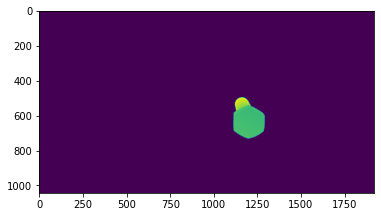

In [23]:
plt.imshow(test_images[5].depth)

In [96]:
from utility.scoring_client import get_highscores, get_myscores, Challenge
get_highscores(Challenge.POSE)

Your Ranking: #90
                           score
name                            
"kxrider"             -14.555914
'Goof Josh            -14.555914
'gust141999           -14.555914
Brigyth               -14.555914
CapnCrunch            -14.555914
Catherine Duong        -6.615265
Fxnchy                 -6.679010
Goof Josh              -6.622292
Haoshen               -14.555914
Josiah                -14.555914
Katherine_Stevens      -6.679010
Legolas                -8.393034
Mavert                 -6.632729
Robot Faust Stoneware  -6.622292
Seth Hamilton          -6.679010
Srujana               -14.555914
THANOS                -14.555914
YoungBreezy            -1.154201
ananththebunth         -6.622292
bhanu                 -14.555914
conor                  -0.604942
cz_zhao                -6.679010
danbeltran             -6.622292
fardeenmozumder        -6.475283
hieule                 -6.622292
josiah                 -6.615265
kxrider                -6.679010
marbhic                -6

In [33]:
get_myscores(Challenge.COMBINED)

[70.04891526763545]

# Robot Control Challenge

In [36]:
from utility.remote_env import RobotorqueEnvironment
from tqdm import tqdm 

env = RobotorqueEnvironment(Challenge.ROBOT)
state = env.reset()
history = []
for _ in tqdm(list(range(10))):
    robot_positions = [state['bolt_pose'].translation[1]] * env.CONTROLS_PER_CAPTURE
    state, reward, done, info = env.step(robot_positions)
    info['rewards'] = reward
    history.append(info)

import pandas as pd
df = pd.DataFrame(history).round(3)
print(df)
print('Total Reward:', df.rewards.sum().round(1))
if done:
  print('Ranking', info['ranking'])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.33it/s]

   bolt position                            robot visited positions  time  \
0          9.408                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.02   
1         -7.270  [2.0, 4.0, 6.0, 8.0, 9.407544652822464, 9.4075...  0.04   
2         -2.996  [7.407544652822464, 5.407544652822464, 3.40754...  0.06   
3         11.403  [-5.270152569827219, -3.2701525698272187, -2.9...  0.08   
4         -3.352  [-0.9955683545544631, 1.0044316454455369, 3.00...  0.10   
5         -4.716  [9.403215991401174, 7.403215991401174, 5.40321...  0.12   
6         13.241  [-4.715976864919076, -4.715976864919076, -4.71...  0.14   
7          2.381  [-2.7159768649190763, -0.7159768649190763, 1.2...  0.16   
8         -4.740  [11.241397737893761, 9.241397737893761, 7.2413...  0.18   
9         14.857  [0.38114153041841314, -1.6188584695815869, -3....  0.20   

   rewards  
0    0.000  
1    0.000  
2    0.725  
3    0.000  
4    0.000  
5    3.636  
6    0.000  
7    0.000  
8    0.000  
9    0.000  
Total Rew

In [37]:
from utility.remote_env import RobotorqueEnvironment
from tqdm import tqdm 

env = RobotorqueEnvironment(Challenge.COMBINED)
state = env.reset()
history = []
for _ in tqdm(list(range(200))):
    robot_positions = [estimator(state['bolt_pose']).translation[1]] * env.CONTROLS_PER_CAPTURE
    state, reward, done, info = env.step(robot_positions)
    info['rewards'] = reward
    history.append(info)

import pandas as pd
df = pd.DataFrame(history).round(3)
print(df)
print('Total Reward:', df.rewards.sum().round(1))
if done:
  print('Ranking', info['ranking'])

  0%|                                                                                                                                                                                      | 0/200 [00:00<?, ?it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  0%|▊                                                                                                                                                                             | 1/200 [00:00<01:22,  2.42it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  1%|█▋                                                                                                                                                                            | 2/200 [00:00<01:21,  2.42it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  2%|██▌                                                                                                                                                                           | 3/200 [00:01<01:21,  2.41it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  2%|███▍                                                                                                                                                                          | 4/200 [00:01<01:18,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  2%|████▎                                                                                                                                                                         | 5/200 [00:02<01:18,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  3%|█████▏                                                                                                                                                                        | 6/200 [00:02<01:18,  2.47it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  4%|██████                                                                                                                                                                        | 7/200 [00:02<01:17,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  4%|██████▉                                                                                                                                                                       | 8/200 [00:03<01:16,  2.52it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  4%|███████▊                                                                                                                                                                      | 9/200 [00:03<01:14,  2.55it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  5%|████████▋                                                                                                                                                                    | 10/200 [00:03<01:13,  2.57it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  6%|█████████▌                                                                                                                                                                   | 11/200 [00:04<01:12,  2.61it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  6%|██████████▍                                                                                                                                                                  | 12/200 [00:04<01:12,  2.60it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  6%|███████████▏                                                                                                                                                                 | 13/200 [00:05<01:13,  2.54it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  7%|████████████                                                                                                                                                                 | 14/200 [00:05<01:13,  2.53it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  8%|████████████▉                                                                                                                                                                | 15/200 [00:05<01:14,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  8%|█████████████▊                                                                                                                                                               | 16/200 [00:06<01:15,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  8%|██████████████▋                                                                                                                                                              | 17/200 [00:06<01:15,  2.41it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


  9%|███████████████▌                                                                                                                                                             | 18/200 [00:07<01:14,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 10%|████████████████▍                                                                                                                                                            | 19/200 [00:07<01:13,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 10%|█████████████████▎                                                                                                                                                           | 20/200 [00:08<01:12,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 10%|██████████████████▏                                                                                                                                                          | 21/200 [00:08<01:12,  2.47it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 11%|███████████████████                                                                                                                                                          | 22/200 [00:08<01:11,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 12%|███████████████████▉                                                                                                                                                         | 23/200 [00:09<01:11,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 12%|████████████████████▊                                                                                                                                                        | 24/200 [00:09<01:11,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 12%|█████████████████████▋                                                                                                                                                       | 25/200 [00:10<01:09,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 13%|██████████████████████▍                                                                                                                                                      | 26/200 [00:10<01:10,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 14%|███████████████████████▎                                                                                                                                                     | 27/200 [00:10<01:09,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 14%|████████████████████████▏                                                                                                                                                    | 28/200 [00:11<01:09,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 14%|█████████████████████████                                                                                                                                                    | 29/200 [00:11<01:08,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 15%|█████████████████████████▉                                                                                                                                                   | 30/200 [00:12<01:08,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 16%|██████████████████████████▊                                                                                                                                                  | 31/200 [00:12<01:07,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 16%|███████████████████████████▋                                                                                                                                                 | 32/200 [00:12<01:07,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 16%|████████████████████████████▌                                                                                                                                                | 33/200 [00:13<01:06,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 17%|█████████████████████████████▍                                                                                                                                               | 34/200 [00:13<01:06,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 18%|██████████████████████████████▎                                                                                                                                              | 35/200 [00:14<01:06,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 18%|███████████████████████████████▏                                                                                                                                             | 36/200 [00:14<01:05,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 18%|████████████████████████████████                                                                                                                                             | 37/200 [00:14<01:04,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 19%|████████████████████████████████▊                                                                                                                                            | 38/200 [00:15<01:03,  2.54it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 20%|█████████████████████████████████▋                                                                                                                                           | 39/200 [00:15<01:03,  2.52it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 20%|██████████████████████████████████▌                                                                                                                                          | 40/200 [00:16<01:04,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 20%|███████████████████████████████████▍                                                                                                                                         | 41/200 [00:16<01:05,  2.44it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 21%|████████████████████████████████████▎                                                                                                                                        | 42/200 [00:16<01:04,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 22%|█████████████████████████████████████▏                                                                                                                                       | 43/200 [00:17<01:04,  2.44it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 22%|██████████████████████████████████████                                                                                                                                       | 44/200 [00:17<01:03,  2.44it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 22%|██████████████████████████████████████▉                                                                                                                                      | 45/200 [00:18<01:03,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 23%|███████████████████████████████████████▊                                                                                                                                     | 46/200 [00:18<01:02,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 24%|████████████████████████████████████████▋                                                                                                                                    | 47/200 [00:18<01:02,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 24%|█████████████████████████████████████████▌                                                                                                                                   | 48/200 [00:19<01:01,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 24%|██████████████████████████████████████████▍                                                                                                                                  | 49/200 [00:19<01:00,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 25%|███████████████████████████████████████████▎                                                                                                                                 | 50/200 [00:20<01:00,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 26%|████████████████████████████████████████████                                                                                                                                 | 51/200 [00:20<00:59,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 26%|████████████████████████████████████████████▉                                                                                                                                | 52/200 [00:20<00:59,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 26%|█████████████████████████████████████████████▊                                                                                                                               | 53/200 [00:21<00:59,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 27%|██████████████████████████████████████████████▋                                                                                                                              | 54/200 [00:21<00:59,  2.44it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 28%|███████████████████████████████████████████████▌                                                                                                                             | 55/200 [00:22<00:59,  2.44it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 28%|████████████████████████████████████████████████▍                                                                                                                            | 56/200 [00:22<00:58,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 28%|█████████████████████████████████████████████████▎                                                                                                                           | 57/200 [00:22<00:57,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 29%|██████████████████████████████████████████████████▏                                                                                                                          | 58/200 [00:23<00:56,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 30%|███████████████████████████████████████████████████                                                                                                                          | 59/200 [00:23<00:56,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 30%|███████████████████████████████████████████████████▉                                                                                                                         | 60/200 [00:24<00:56,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 30%|████████████████████████████████████████████████████▊                                                                                                                        | 61/200 [00:24<00:55,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 31%|█████████████████████████████████████████████████████▋                                                                                                                       | 62/200 [00:24<00:54,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 32%|██████████████████████████████████████████████████████▍                                                                                                                      | 63/200 [00:25<00:54,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 32%|███████████████████████████████████████████████████████▎                                                                                                                     | 64/200 [00:25<00:54,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 32%|████████████████████████████████████████████████████████▏                                                                                                                    | 65/200 [00:26<00:54,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 33%|█████████████████████████████████████████████████████████                                                                                                                    | 66/200 [00:26<00:53,  2.52it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 34%|█████████████████████████████████████████████████████████▉                                                                                                                   | 67/200 [00:26<00:52,  2.53it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 34%|██████████████████████████████████████████████████████████▊                                                                                                                  | 68/200 [00:27<00:52,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 34%|███████████████████████████████████████████████████████████▋                                                                                                                 | 69/200 [00:27<00:52,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 35%|████████████████████████████████████████████████████████████▌                                                                                                                | 70/200 [00:28<00:52,  2.47it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 36%|█████████████████████████████████████████████████████████████▍                                                                                                               | 71/200 [00:28<00:51,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 36%|██████████████████████████████████████████████████████████████▎                                                                                                              | 72/200 [00:28<00:51,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 36%|███████████████████████████████████████████████████████████████▏                                                                                                             | 73/200 [00:29<00:50,  2.52it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 37%|████████████████████████████████████████████████████████████████                                                                                                             | 74/200 [00:29<00:49,  2.54it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 38%|████████████████████████████████████████████████████████████████▉                                                                                                            | 75/200 [00:30<00:50,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                           | 76/200 [00:30<00:48,  2.54it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                          | 77/200 [00:30<00:48,  2.54it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                         | 78/200 [00:31<00:47,  2.55it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                        | 79/200 [00:31<00:47,  2.56it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 80/200 [00:32<00:47,  2.55it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 40%|██████████████████████████████████████████████████████████████████████                                                                                                       | 81/200 [00:32<00:46,  2.56it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                      | 82/200 [00:32<00:46,  2.53it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                     | 83/200 [00:33<00:46,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                    | 84/200 [00:33<00:45,  2.52it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                   | 85/200 [00:34<00:45,  2.52it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 43%|██████████████████████████████████████████████████████████████████████████▍                                                                                                  | 86/200 [00:34<00:45,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                                 | 87/200 [00:34<00:45,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 44%|████████████████████████████████████████████████████████████████████████████                                                                                                 | 88/200 [00:35<00:45,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 44%|████████████████████████████████████████████████████████████████████████████▉                                                                                                | 89/200 [00:35<00:45,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                               | 90/200 [00:36<00:44,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                              | 91/200 [00:36<00:44,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 46%|███████████████████████████████████████████████████████████████████████████████▌                                                                                             | 92/200 [00:36<00:43,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 46%|████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 93/200 [00:37<00:43,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 47%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 94/200 [00:37<00:43,  2.41it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 95/200 [00:38<00:43,  2.42it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                          | 96/200 [00:38<00:42,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 48%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 97/200 [00:38<00:41,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 49%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 98/200 [00:39<00:40,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 99/200 [00:39<00:40,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 100/200 [00:40<00:40,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 50%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 101/200 [00:40<00:40,  2.47it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 51%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 102/200 [00:40<00:39,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 103/200 [00:41<00:39,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 104/200 [00:41<00:38,  2.47it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 105/200 [00:42<00:38,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 53%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 106/200 [00:42<00:38,  2.47it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 107/200 [00:42<00:37,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 108/200 [00:43<00:36,  2.54it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 109/200 [00:43<00:36,  2.52it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 110/200 [00:44<00:35,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 111/200 [00:44<00:35,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 112/200 [00:44<00:35,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 113/200 [00:45<00:35,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 114/200 [00:45<00:34,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 115/200 [00:46<00:34,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 116/200 [00:46<00:33,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 117/200 [00:46<00:33,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 118/200 [00:47<00:32,  2.53it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 119/200 [00:47<00:32,  2.53it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 120/200 [00:48<00:31,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 121/200 [00:48<00:31,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 122/200 [00:48<00:31,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 123/200 [00:49<00:30,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 124/200 [00:49<00:30,  2.52it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 125/200 [00:50<00:30,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 126/200 [00:50<00:29,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 127/200 [00:50<00:29,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 128/200 [00:51<00:28,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 129/200 [00:51<00:28,  2.52it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 130/200 [00:52<00:27,  2.55it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 131/200 [00:52<00:27,  2.54it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 132/200 [00:52<00:26,  2.54it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 133/200 [00:53<00:26,  2.53it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 134/200 [00:53<00:26,  2.52it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 135/200 [00:54<00:25,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 136/200 [00:54<00:25,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 137/200 [00:54<00:25,  2.47it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 138/200 [00:55<00:24,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 139/200 [00:55<00:24,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 140/200 [00:56<00:24,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 141/200 [00:56<00:23,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 142/200 [00:56<00:23,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 143/200 [00:57<00:23,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 144/200 [00:57<00:22,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 145/200 [00:58<00:22,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 146/200 [00:58<00:21,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 147/200 [00:58<00:21,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 148/200 [00:59<00:20,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 149/200 [00:59<00:20,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 150/200 [01:00<00:20,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 151/200 [01:00<00:19,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 152/200 [01:00<00:19,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 153/200 [01:01<00:18,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 154/200 [01:01<00:18,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 155/200 [01:02<00:17,  2.51it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 156/200 [01:02<00:17,  2.52it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 157/200 [01:02<00:17,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 158/200 [01:03<00:16,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 159/200 [01:03<00:16,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 160/200 [01:04<00:16,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 161/200 [01:04<00:15,  2.47it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 162/200 [01:05<00:15,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 163/200 [01:05<00:14,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 164/200 [01:05<00:14,  2.47it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 165/200 [01:06<00:14,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 166/200 [01:06<00:13,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 167/200 [01:07<00:13,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 168/200 [01:07<00:12,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 169/200 [01:07<00:12,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 170/200 [01:08<00:12,  2.47it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 171/200 [01:08<00:11,  2.44it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 172/200 [01:09<00:11,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 173/200 [01:09<00:11,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 174/200 [01:09<00:10,  2.50it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 175/200 [01:10<00:10,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 176/200 [01:10<00:09,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 177/200 [01:11<00:09,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 178/200 [01:11<00:08,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 179/200 [01:11<00:08,  2.47it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 180/200 [01:12<00:08,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 181/200 [01:12<00:07,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 182/200 [01:13<00:07,  2.47it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 183/200 [01:13<00:06,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 184/200 [01:13<00:06,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 185/200 [01:14<00:06,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 186/200 [01:14<00:05,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 187/200 [01:15<00:05,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 188/200 [01:15<00:04,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 189/200 [01:15<00:04,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 190/200 [01:16<00:04,  2.48it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 191/200 [01:16<00:03,  2.46it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 192/200 [01:17<00:03,  2.41it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 193/200 [01:17<00:02,  2.45it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 194/200 [01:18<00:02,  2.44it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 195/200 [01:18<00:02,  2.43it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 196/200 [01:18<00:01,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 197/200 [01:19<00:01,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 198/200 [01:19<00:00,  2.49it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 199/200 [01:19<00:00,  2.53it/s]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:20<00:00,  2.48it/s]

     bolt position         robot visited positions  time  rewards  \
0            9.616  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.02    0.000   
1           -6.461  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.04    0.000   
2           -1.230  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.06    3.770   
3           14.605  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.08    0.000   
4            1.685  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.10    3.315   
..             ...                             ...   ...      ...   
195        470.020  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  3.92    0.000   
196        384.265  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  3.94    0.000   
197        423.410  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  3.96    0.000   
198        533.407  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  3.98    0.000   
199        466.654  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  4.00    0.000   

                                               ranking  
0                                                  NaN  
1                                                  NaN  


In [17]:
from dtw import accelerated_dtw
from scipy.spatial.distance import cosine
import numpy as np
import matplotlib.pyplot as plt

In [184]:
X = np.load("X.npy")

In [ ]:
X.shape

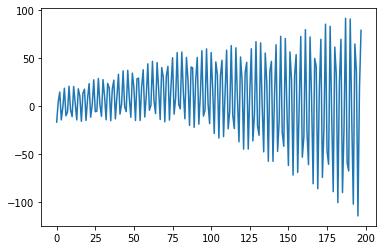

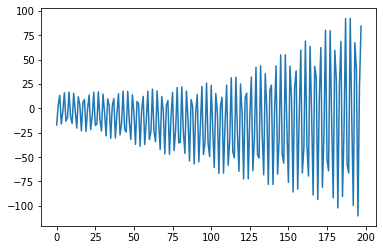

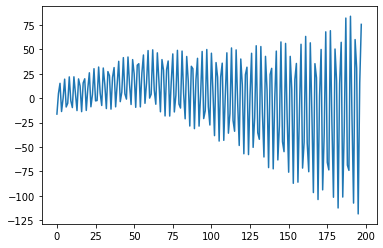

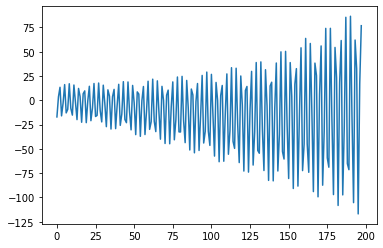

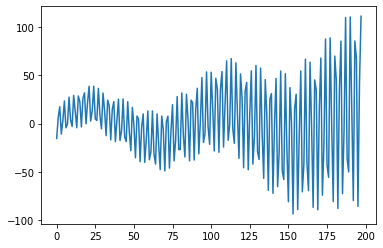

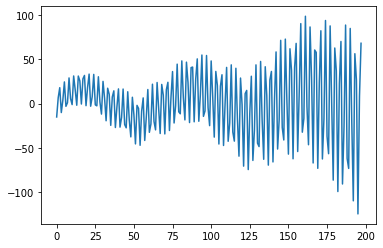

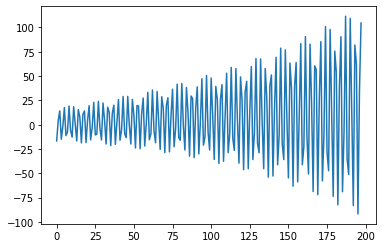

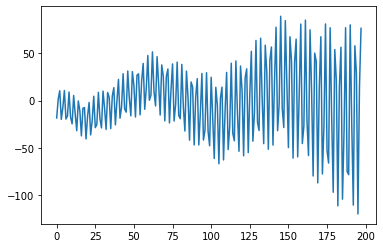

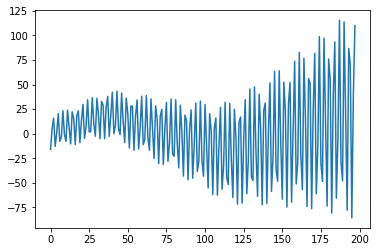

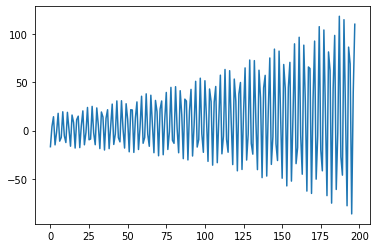

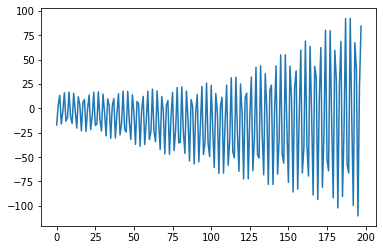

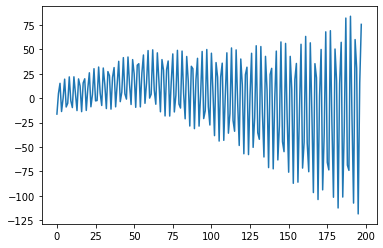

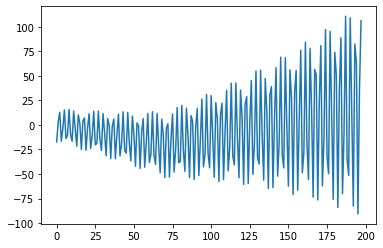

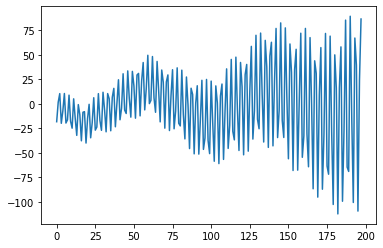

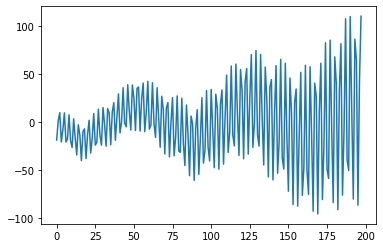

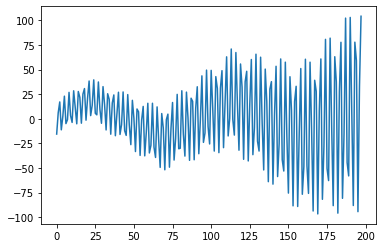

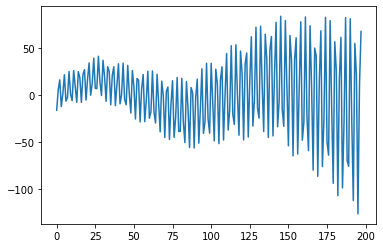

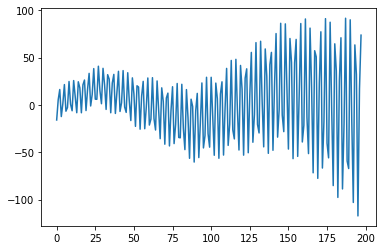

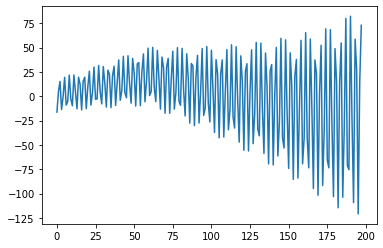

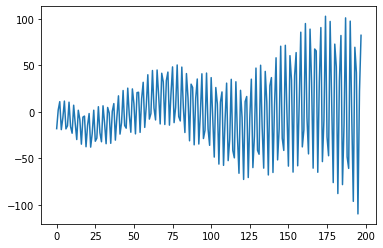

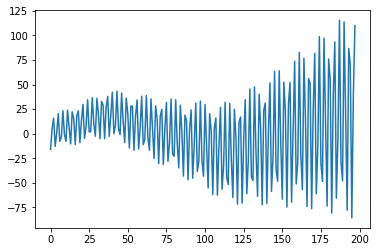

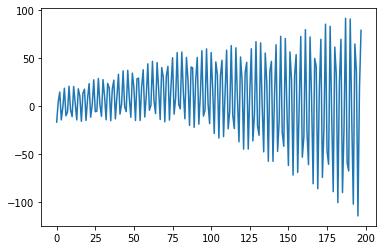

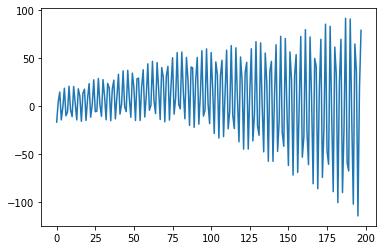

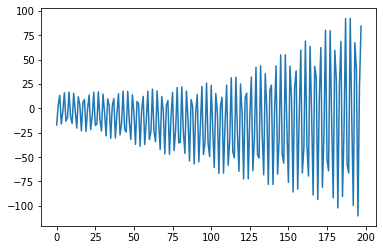

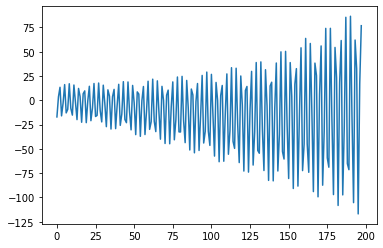

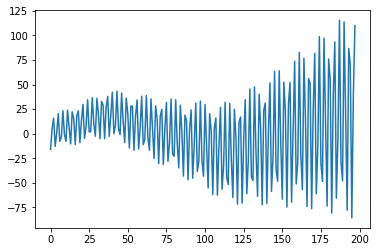

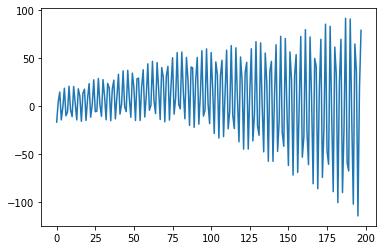

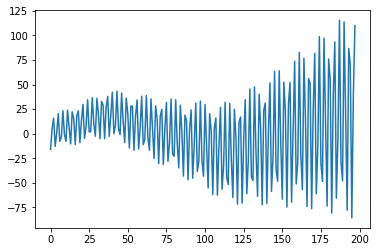

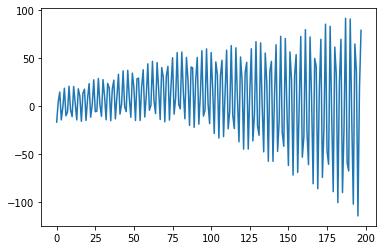

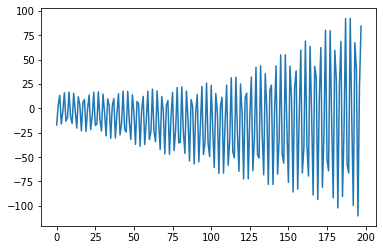

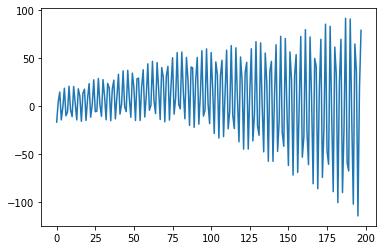

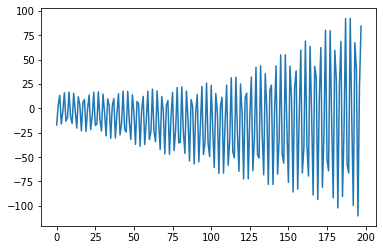

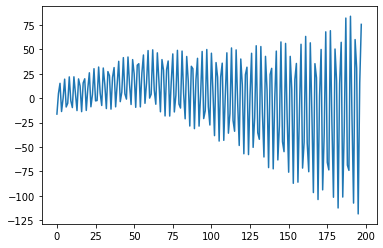

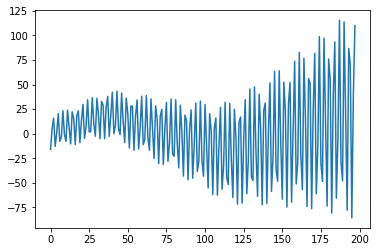

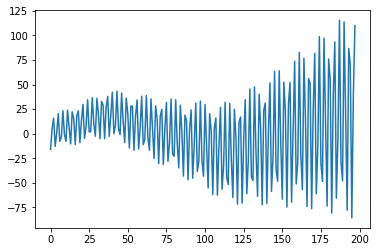

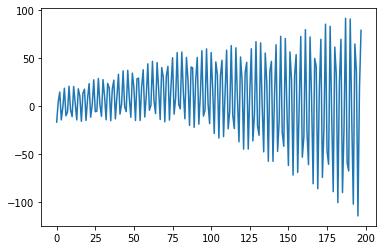

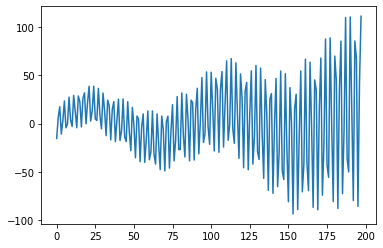

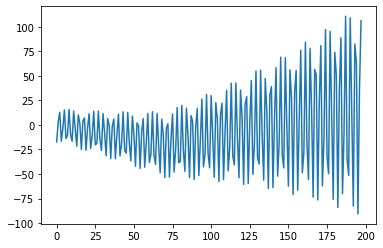

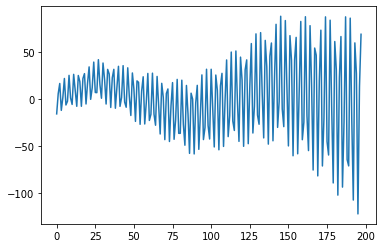

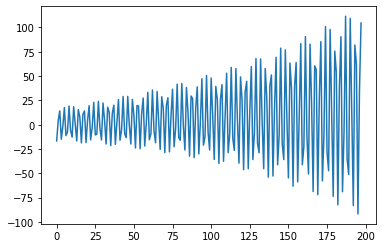

In [187]:
X_dif = list()
for i in range(0,40):
    plt.plot(np.diff(X[i,:]))
    plt.show()

In [ ]:
X_dif = np.array(X_dif)

In [ ]:
# tt = np.diff(X[:,:])
# tt = tt.clip(0,200)
tt.shape

In [188]:
from scipy import interpolate
tt = np.diff(X[:,:])
tt = tt.clip(0,200)

Averaged_sig = list()
for i in range(0,40):
    tt = np.diff(X[:,:])
    tt = tt.clip(0,200)
    tt = tt[i,tt[i,:]!=0]
    f = interpolate.interp1d(np.arange(0,len(tt)), tt)
    ynew = np.linspace(0,len(tt)-1,199)
    tt = f(ynew)
    Averaged_sig.append(tt)
# Averaged_sig = np.mean(tt,0)

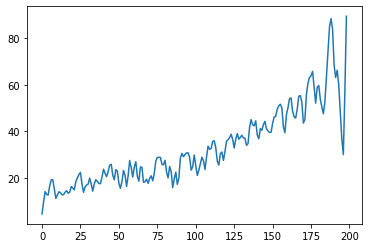

In [189]:
plt.plot(np.mean(Averaged_sig,0))

In [ ]:
from scipy.signal import savgol_filter
Averaged_sig = np.mean(Averaged_sig,0)
yhat = savgol_filter(Averaged_sig, 51, 3) # window size 51, polynomial order 3
plt.plot(yhat)
plt.plot(Averaged_sig)

In [ ]:
from utility.remote_env import RobotorqueEnvironment
from tqdm import tqdm 

env = RobotorqueEnvironment(Challenge.ROBOT)
state = env.reset()
history = []
manhattan_distance = lambda x, y: np.abs(x - y)

pred = list()
actual = list()
for j in (range(200)):
    idx = list()
    if j == 0:
        robot_positions = [np.mean((X[:,0]))] * env.CONTROLS_PER_CAPTURE
#         pred.append(np.mean((X[:,0])))
    elif j>0 and j<30:
        robot_positions = [actual[j-1]+np.mean((X_dif[:,j-1]))]* env.CONTROLS_PER_CAPTURE
#         pred.append(actual[j-1])
#     robot_positions = [state['bolt_pose'].translation[1]] * env.CONTROLS_PER_CAPTURE
    else:
        act_diff = np.diff(actual)
        idx = list()
# #         for jj in range(0,40):
# #             d, not_n, not_ne2,path = accelerated_dtw(X_dif[jj,0:j-1],act_diff,dist='cosine')
# #             idx.append(d)
        
#         idx = int(np.min(idx))
        if actual[j-1] <= 0:
            if Averaged_sig[j-1] == 0:
                robot_positions = [actual[j-1]+Averaged_sig[j]]* env.CONTROLS_PER_CAPTURE
            elif Averaged_sig[j-1] > 0:
                robot_positions = [actual[j-1]+Averaged_sig[j-1]]* env.CONTROLS_PER_CAPTURE
        elif actual[j-1] > 0:
            if np.diff(actual)[-1] > 0 and np.diff(actual)[-2] > 0:
                robot_positions = [state['robot_pose'].translation[1]]* env.CONTROLS_PER_CAPTURE
            elif np.diff(actual)[-1] < 0 and np.diff(actual)[-2] < 0:
                robot_positions = [state['robot_pose'].translation[1]+Averaged_sig[j]]* env.CONTROLS_PER_CAPTURE
            else:
                robot_positions = [state['robot_pose'].translation[1]+Averaged_sig[j]]* env.CONTROLS_PER_CAPTURE
#                 pred.append(actual[j-1]+(X_dif[idx,j]))
    pred.append(robot_positions[-1])
    state, reward, done, info = env.step(robot_positions)
    actual.append(state['bolt_pose'].translation[1])
    info['rewards'] = reward
    history.append(info)
    print(reward)

import pandas as pd
df = pd.DataFrame(history).round(3)
print(df)
print('Total Reward:', df.rewards.sum().round(1))
if done:
  print('Ranking', info['ranking'])

In [ ]:
robot_positions

In [ ]:
plt.plot(pred)
plt.plot(actual)